
Este notebook se realiza para ejecutar distintas pruebas a las variables meteorológicas que servirán como predictores en el desarrollo del modelo de pronóstico de temperatura mínima

In [ ]:
# Librerias Necesarias
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import r2_score
import warnings
import pandas as pd
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from feature_selector import FeatureSelector
from sklearn.feature_selection import SelectKBest, chi2

In [27]:
# Rutas de los diferentes datos y de guardado de graficas 
ruta1 = 'D:/Documentos/Maestria/DATOS ERA5/ERA5/DATASET_ERA5.nc'
ruta = 'D:/Documentos/Maestria/INTELIGENCIA ARTIFICIAL EN GEOCIENCIAS/VARS_DF.csv'
save = 'D:/Documentos/Maestria/INTELIGENCIA ARTIFICIAL EN GEOCIENCIAS/IMGS/'
ruta2 = 'D:/Documentos/Maestria/DATOS ERA5/ERA5/ERA5v2/'
mpl.rcParams["axes.formatter.limits"]=[-2, 3]

In [3]:
# Lectura de los datos de ERA5 
data = xr.open_mfdataset(ruta2+'*.nc')

In [4]:
# Filtro de fecha. ERA5 consolida sus datos con una frecuencia de 3 meses con lo cual se ignoran los ultimos datos.
st_time = data.time[0]
ed_time = '2021-05-31'
sub_time = slice(st_time, ed_time)
data = data.sel(time = sub_time)

In [28]:
# Se seleccionan todas las variables a excepcion de la temperatura minima
cols = list(data.keys())
cols.remove('mn2t')
scaler = StandardScaler()

In [6]:
# Se agrupan los datos en frecuencias horarias y mensuales para observar 
#los comportamientos de las variables en comparacion a la temp minima
data_m = data.groupby('time.month').mean()
data_h = data.groupby('time.hour').mean()

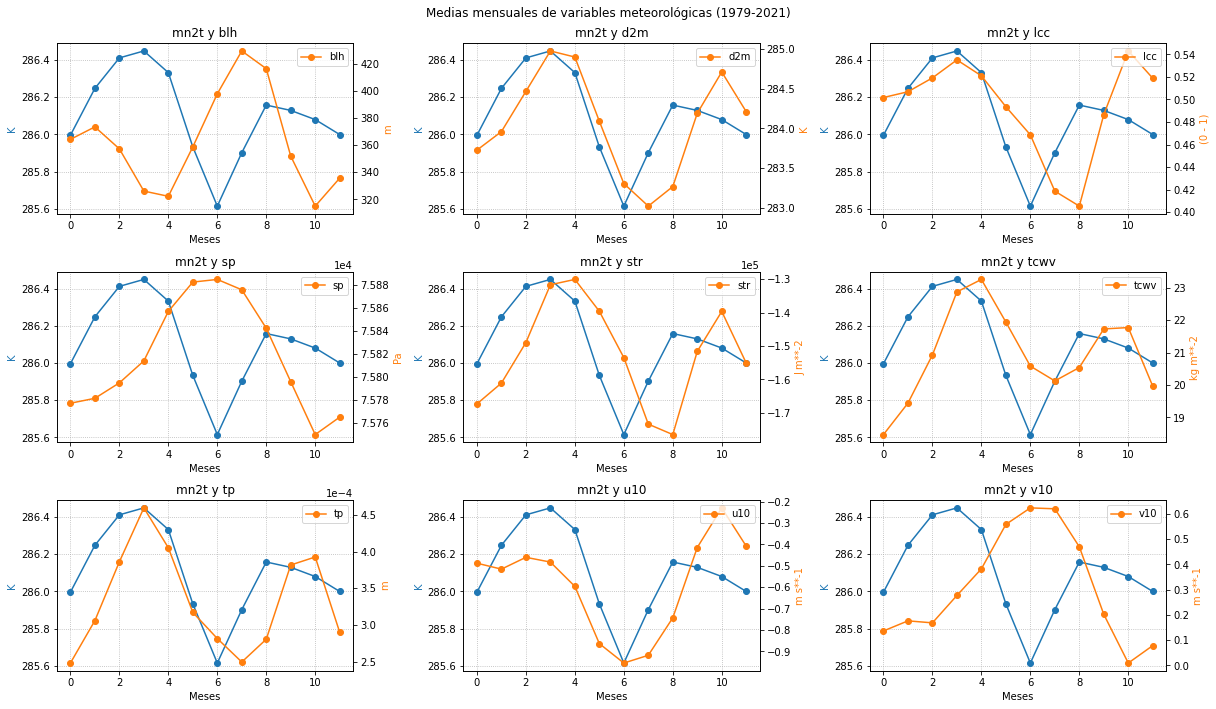

In [34]:
# Loop para graficar las medias mensuales multianuales
fig = plt.figure(figsize=(17,10))
fig.suptitle('Medias mensuales de variables meteorológicas (1979-2021)')
for i in range(len(cols)):
    # vectores a graficar
    tm  = data_m.mn2t.mean(axis=(1,2),skipna=True) 
    var = data_m[cols[i]].mean(axis=(1,2),skipna=True) 
    
    ax = plt.subplot(3,3,i+1)
    ax.plot(tm, '-o', c='tab:blue', label='mn2t')
    ax2 = ax.twinx() 
    ax2.plot(var, '-o', c='tab:orange', label=cols[i])

    ax2.legend(loc='upper right')
    ax.set_title('mn2t y '+cols[i])
    ax.set_xlabel('Meses')
    ax.set_ylabel(data['mn2t'].attrs['units'], c='tab:blue')
    ax2.set_ylabel(data[cols[i]].attrs['units'], c='tab:orange')
    
    ax.grid(ls=':')
    plt.tight_layout()
plt.savefig(save+'Month_Mean.png',dpi=300)

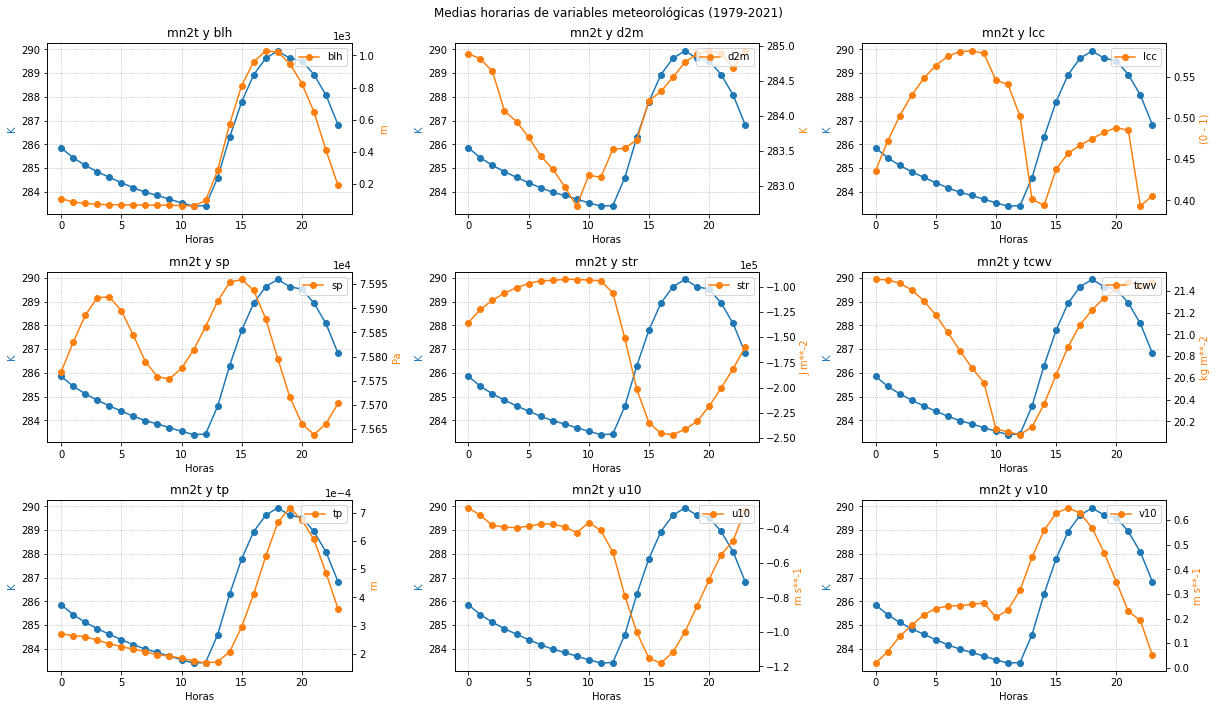

In [35]:
# Loop para graficar las medias horarias multianuales
fig = plt.figure(figsize=(17,10))
fig.suptitle('Medias horarias de variables meteorológicas (1979-2021)')
for i in range(len(cols)):
    # vectores a graficar
    tm  = data_h.mn2t.mean(axis=(1,2),skipna=True) 
    var = data_h[cols[i]].mean(axis=(1,2),skipna=True) 
    
    ax = plt.subplot(3,3,i+1)
    ax.plot(tm, '-o', c='tab:blue', label='mn2t')
    ax2 = ax.twinx() 
    ax2.plot(var, '-o', c='tab:orange', label=cols[i])

    ax2.legend(loc='upper right')
    ax.set_title('mn2t y '+cols[i])
    ax.set_xlabel('Horas')
    ax.set_ylabel(data['mn2t'].attrs['units'], c='tab:blue')
    ax2.set_ylabel(data[cols[i]].attrs['units'], c='tab:orange')
    
    ax.grid(ls=':')
    plt.tight_layout()
plt.savefig(save+'Hourly_Mean.png',dpi=300)

### Preprocessing

In [5]:
# Lectura de datos consolidados
data = xr.open_dataset(ruta1)

In [4]:
# Selecion de las fechas especificadas
st_time = data.time[0]
#st_time = '2010-01-01'
ed_time = '2021-05-31'
sub_time = slice(st_time, ed_time)
data = data.sel(time = sub_time)

In [5]:
var_names = list(data.keys())

In [ ]:
y = data.mn2t[:,32,0].values
-# - Seleccion de variables exceptuando temp
X = data.drop('mn2t')
X = X.sel(latitude = 0.0, longitude = -78.5)
X = X.to_array().values
-# - Transponer para tener shape (n_samples, n_features)
X = np.transpose(X)

### Var_selection

In [18]:
# lectura de los datos transformados en dataframe
df = pd.read_csv(ruta)

In [10]:
# Limpieza de datos extremos
factor = 1.3
cols = list(df.columns)
for i in range(len(cols)):
    upper_lim = df[cols[i]].mean () + df[cols[i]].std () * factor
    lower_lim = df[cols[i]].mean () - df[cols[i]].std () * factor
    
    df = df[(df[cols[i]] < upper_lim) & (df[cols[i]] > lower_lim)]

In [11]:
# Estandarixacion de las variables
media = df.mean()
std = df.std()
cols = list(df.columns)
for i in range(len(cols)):
    df[cols[i]] = (df[cols[i]]-media[i])/std[i]

In [12]:
# - Dataframes de entrenamiento y datos
y = df['mn2t']
x = df.drop(['mn2t'], axis =1)
cols = list(x.columns)

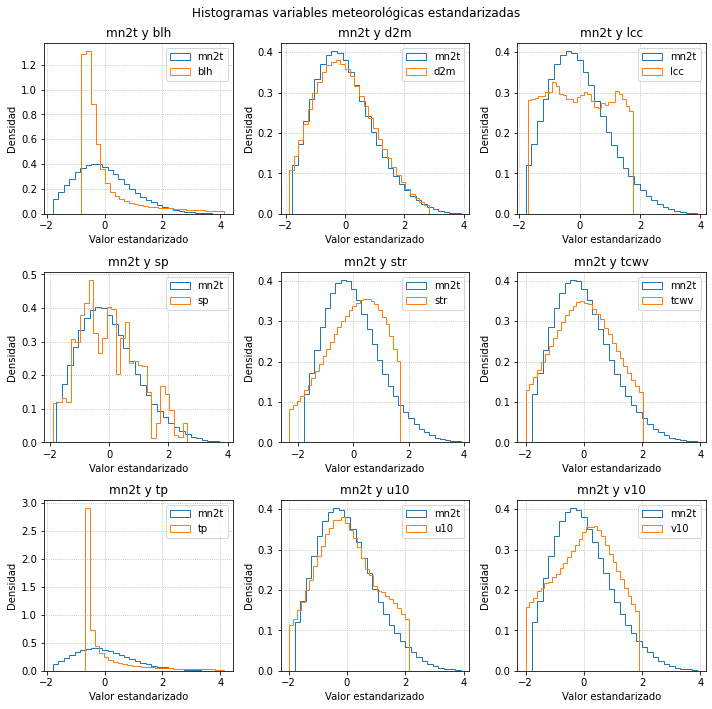

In [15]:
# Histogramas de las variables comparadas a la temp min
fig = plt.figure(figsize=(10,10))
fig.suptitle('Histogramas variables meteorológicas estandarizadas')
for i in range(len(cols)):
    ax = plt.subplot(3,3,i+1)
    ax.hist(y, bins = 30, density=True, histtype = 'step', label = 'mn2t')
    ax.hist(x[cols[i]], bins = 30, density=True, histtype = 'step', label = cols[i])
    ax.legend(loc='upper right')
    ax.set_title('mn2t y '+cols[i])
    ax.set_xlabel('Valor estandarizado')
    ax.set_ylabel('Densidad')
    ax.grid(ls=':')
    plt.tight_layout()
plt.savefig(save+'HISTOGRAMAS.png',dpi=300)

In [19]:
# Matriz de correlacion
corr = df.corr()

In [11]:
# - Creacion de instancia de feature selector
fs = FeatureSelector(data = x, labels = y)

In [12]:
# -Aplicacion de pruebas con feature selection
fs.missing_stats
fs.identify_missing(missing_threshold=0.3)
fs.identify_single_unique()
single_unique = fs.ops['single_unique']
single_unique
fs.unique_stats.sample(5)
fs.identify_collinear(correlation_threshold=0.5)
correlated_features = fs.ops['collinear']
correlated_features
fs.record_collinear

In [ ]:
fs.identify_low_importance(cumulative_importance = 0.99)
low_importance_features = fs.ops['low_importance']
low_importance_features

sns.pairplot(df, kind="hist", diag_kind='kde', corner=True)

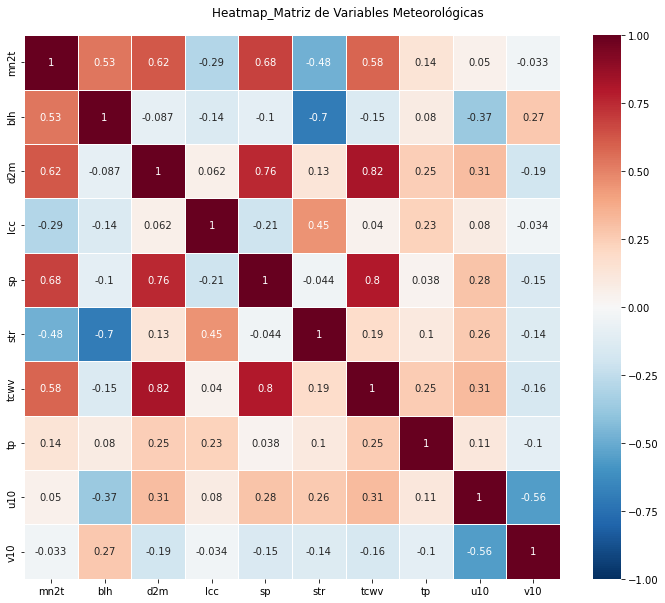

In [20]:
# Plot de la matriz de correlacion
fig = plt.figure(figsize=(12,10))
fig.suptitle('Heatmap_Matriz de Variables Meteorológicas', y=0.92)
sns.heatmap(corr,vmin=-1,vmax=1,center=0,cmap='RdBu_r',
            annot = True, linewidths=.5,
            xticklabels=corr.columns,
            yticklabels=corr.columns)
plt.savefig(save+'CORR_MATRIX_HM.png', dpi = 300)

In [24]:
scaler = StandardScaler()

In [25]:
scaler.fit(df)

StandardScaler()

In [26]:
df2 = scaler.transform(df)

In [29]:
y = df2[:,0]
X = df2[:,1:]

In [ ]:
X_new = SelectKBest(chi2, k=5).fit_transform(X, y)

In [21]:
coors = df.corr()

In [25]:
coors.abs().sum()

mn2t    4.414255
blh     3.423765
d2m     4.230199
lcc     2.534496
sp      4.066631
str     3.492187
tcwv    4.311902
tp      2.294806
u10     3.338205
v10     2.644409
dtype: float64

In [10]:
y = df2[:,0]
X = df2[:,1:]

In [11]:
df.shape

(42511680, 10)

In [ ]:
# Se intenta usar RFE pero consume muchos recursos computacionales
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

### Ejemplo con corrlaciones en cada pixel

In [6]:
corr_matrix = np.zeros((11, 11, 33, 29))*np.nan

In [7]:
corr_sub = np.zeros_like(data.mn2t[0])

In [79]:
for i in range(len(data.latitude)):
    for j in range(len(data.longitude)):
        corr_sub[i,j] = np.corrcoef(data.mn2t[:,i,j], 
                                    data.tcc[:,i,j])[0,1]

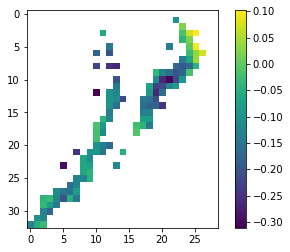

In [81]:
plt.imshow(corr_sub)
plt.colorbar()

In [37]:
for i in range(len(var_names)):
    for j in range(len(var_names)):
        corr = xr.corr(data[var_names[i]],data[var_names[j]],dim='time')
        corr_matrix[i,j] = corr

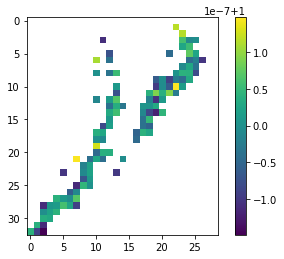

In [50]:
plt.imshow(corr_matrix[0,0])
plt.colorbar()